<a href="https://colab.research.google.com/github/geekquad/Facial-Recognition-with-PCA/blob/master/Face_Recognition_PCA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Necessary Libraries:

In [30]:
import pandas as pd
import numpy as np
from time import time
import logging
import matplotlib.pyplot as plt
import pylab as pl

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.svm import SVC

## Loading the Dataset:

In [5]:
faces = fetch_lfw_people('data', min_faces_per_person=70, resize=0.4)

In [6]:
n_samples, h, w = faces.images.shape
np.random.seed(42)

x = faces.data
n_features = x.shape[1]

y = faces.target
target_names = faces.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print( "n_classes: %d" % n_classes)


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


## Splitting the Data into training and testing

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.25, 
                                                    random_state=42)

## Computing PCA:

In [8]:
n_components = 200
print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
t0 = time()

#Creating instances of PCA, initializing with n_components and whiten=True
pca = PCA(n_components=n_components, whiten=True, svd_solver="randomized")
pca = pca.fit(X_train)
print("Done in %0.3fs" %(time()- t0))


Extracting the top 200 eigenfaces from 966 faces
Done in 0.369s


### Projecting the input data on the eigenfaces orthonormal basis:

In [16]:
eigenfaces = pca.components_.reshape((n_components, h, w))

t0=time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("Done in %0.3fs" %(time()- t0))

Done in 0.037s


## Training a SVM Classification Model

In [17]:
param_grid = { 'C': [1e3, 5e3, 1e4, 5e4, 1e5],
               'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1],}

clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, Y_train)

print("Best Estimator found by Grid Search:")
print(clf.best_estimator_)


Best Estimator found by Grid Search:
SVC(C=1000.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.001,
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)


## Evaluation of the Model:

In [27]:
y_pred = clf.predict(X_test_pca)
print(confusion_matrix(Y_test, y_pred, labels=range(n_classes)))
print(classification_report(Y_test, y_pred, target_names=target_names))

[[  9   1   1   2   0   0   0]
 [  2  53   1   3   0   1   0]
 [  2   2  19   2   1   1   0]
 [  2   6   3 129   3   1   2]
 [  0   2   0   1  22   0   0]
 [  0   3   0   2   1   8   1]
 [  0   1   2   2   0   0  31]]
                   precision    recall  f1-score   support

     Ariel Sharon       0.60      0.69      0.64        13
     Colin Powell       0.78      0.88      0.83        60
  Donald Rumsfeld       0.73      0.70      0.72        27
    George W Bush       0.91      0.88      0.90       146
Gerhard Schroeder       0.81      0.88      0.85        25
      Hugo Chavez       0.73      0.53      0.62        15
       Tony Blair       0.91      0.86      0.89        36

         accuracy                           0.84       322
        macro avg       0.78      0.78      0.78       322
     weighted avg       0.84      0.84      0.84       322



## Plotting the most Significance Eigenfaces:

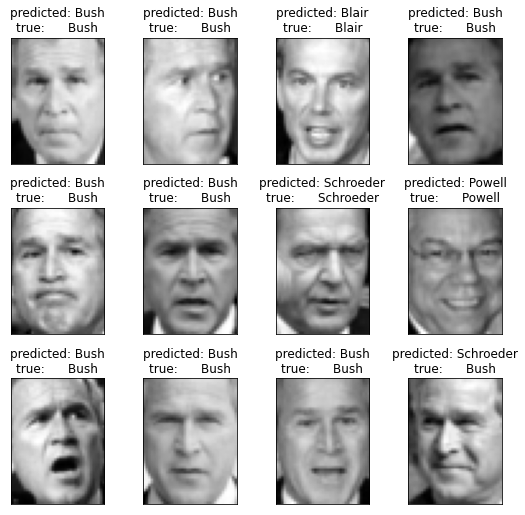

In [33]:
def plot(images, titles, h, w, n_row=4, n_col=4):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())



#Plotting the result of the predictions on a portion of the test set

def title(y_pred, Y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[Y_test[i]].rsplit(' ', 1)[-1]
    return ('predicted: %s\ntrue:      %s' % (pred_name, true_name))

prediction_titles = [title(y_pred, Y_test, target_names, i)
                         for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

pl.show()

## Eigenfaces:

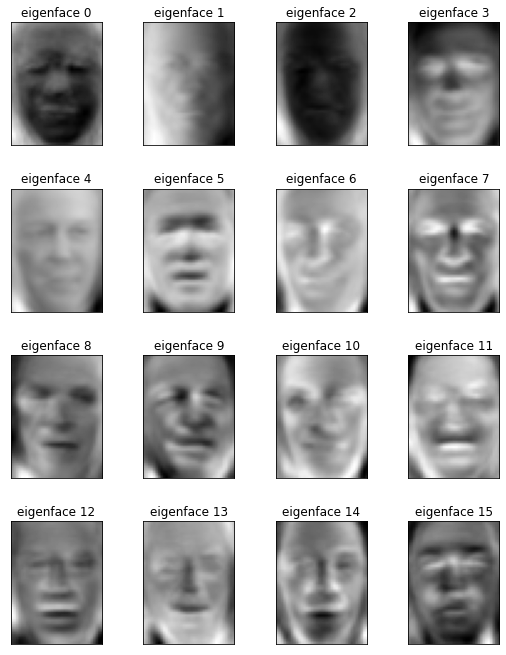

In [36]:
eigenface_titles = ["eigenface %d" %i for i in range(eigenfaces.shape[0])]
plot(eigenfaces, eigenface_titles, h, w)
pl.show()